   # Lab 8
**NAME: SRINATH M KRISHNAN | NET ID: SMK220008**

## Preparation

Use dataset provided in the eLearning

In [8]:
#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 

#Install shap package as needed:
#!pip uninstall numpy
#!pip uninstall numba
#!pip install shap==0.40.0

import shap

import h2o
from h2o.estimators import H2OTargetEncoderEstimator

try:
    h2o.cluster().shutdown()
except:
    pass 

/var/folders/x3/5n0yyb7911zg532jx71xlkrr0000gn/T/ipykernel_35781/3021516139.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [9]:
#Limit to 3 threads and 8GB memory
h2o.init(nthreads=3, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,9 days 2 hours 42 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,3 months and 20 days
H2O_cluster_name:,H2O_from_python_srinathmurali_45aqwl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.777 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,3
H2O_cluster_status:,"locked, healthy"


### Load data

In [15]:
train = h2o.import_file('Car_Prices_Poland_train.csv')
test = h2o.import_file('Car_Prices_Poland_test.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
train.head(5)

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
opel,insignia,gen-a-2008-2017,2009,106125,1796,Gasoline,Częstochowa,Śląskie,25000
skoda,fabia,gen-ii-2007,2010,207000,1200,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900
opel,insignia,gen-a-2008-2017,2013,195000,1956,Diesel,Ruda Śląska,Śląskie,24598
audi,a4,gen-b8-2007-2015,2012,280000,1968,Diesel,Białystok,Podlaskie,41900
citroen,c4-picasso,gen-ii-2013-c4-picasso,2014,122200,1560,Diesel,Dziemionna,Kujawsko-pomorskie,39500


In [19]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (88445, 10)
Test shape: (29482, 10)


In [21]:
train.describe()

Rows:88445
Cols:10

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
type,enum,enum,enum,int,int,int,enum,enum,enum,int
mins,,,,1964.0,0.0,0.0,,,,500.0
mean,,,,2012.933427553847,140832.01954887222,1812.3419074000788,,,,70347.49990389506
maxs,,,,2022.0,2800000.0,7600.0,,,,2399900.0
sigma,,,,5.684015918888904,92510.79953360026,646.7315007474648,,,,85275.90175596683
zeros,,,,0,283,936,,,,0
missing,0,0,22551,0,0,0,0,0,0,0
0,opel,insignia,gen-a-2008-2017,2009.0,106125.0,1796.0,Gasoline,Częstochowa,Śląskie,25000.0
1,skoda,fabia,gen-ii-2007,2010.0,207000.0,1200.0,Gasoline,Bydgoszcz,Kujawsko-pomorskie,11900.0
2,opel,insignia,gen-a-2008-2017,2013.0,195000.0,1956.0,Diesel,Ruda Śląska,Śląskie,24598.0


In [23]:
from h2o.estimators import H2OGradientBoostingEstimator

## Question 1

Train H2O `H2OGradientBoostingEstimator` with parameters:
```
nfolds=5,
ntrees=500,
stopping_rounds=5,
stopping_metric='MAE',
seed=1234,
keep_cross_validation_predictions = False
```
Display model performance on `test` dataset using `model_performance` function.

In [25]:
model = H2OGradientBoostingEstimator(
    nfolds=5,
    ntrees=500,
    stopping_rounds=5,
    stopping_metric='MAE',
    seed=1234,
    keep_cross_validation_predictions=False
)

# Assume 'target' is your target variable and the rest are features
# Replace 'target' with the actual name of your target column
model.train(y='price', training_frame=train)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1711996825619_684


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    291                291                         213399                 5            5            5             9             32            20.5739

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 245839852.2090661
RMSE: 15679.280985079198
MAE: 7458.992308666638
RMSLE: 0.18200564841317668
Mean Residual Deviance: 245839852.2090661

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 425873510.2163639
RMSE: 20636.702988034787
MAE: 8594.433046475779
RMSLE: NaN
Mean Residual Deviance: 425873510.2163639

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     8594.15      214.989      8427.12       8390.56       8932.55       8594.36       8626.14
mean_residual_deviance  4.25985e+08  6.28148e+07  4.81669e+08   3.86456e+08   3.45253e+08   4.22802e+08   4.93747e+08
mse                     4.25985e+08  6.28148e+07  4.81669e+08   3.86456e+08   3.45253e+08   4.22802e+08   4.93747e+08
r2                      0.941526     0.00761734   0.934233      0.947095      0.951006      0.941387      0.93391
residual_deviance       4.25985e+08  6.28148e+07  4.81669e+08   3.86456e+08   3.45253e+08   4.22802e+08   4.93747e+08
rmse                    20593.8      1533.32      21947         19658.5       18581         20562.2       22220.4
rmsle                   0.206946     0.00272094   nan           nan           0.20887       0.205022      nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2024-04-10 16:37:30  28.187 sec  0.0                85275.41967024807   54099.707243764606  7271897199.936933
     2024-04-10 16:37:30  28.216 sec  1.0                77852.96365695648   49180.89934956929   6061083950.171385
     2024-04-10 16:37:30  28.237 sec  2.0                71173.11970956146   44686.06594882413   5065612969.1915655
     2024-04-10 16:37:30  28.253 sec  3.0                65253.69578827685   40686.696648164114  4258044814.02898
     2024-04-10 16:37:30  28.278 sec  4.0                59960.00453829174   37133.13586988206   3595202144.231966
     2024-04-10 16:37:30  28.298 sec  5.0                55219.860556348096  33875.5907242407    3049232999.8625283
     2024-04-10 16:37:30  28.313 sec  6.0                51001.24288695174   30953.80417716342   2601126776.0138454
     2024-04-10 16:37:30  28.328 sec  7.0                47269.46207496309   28364.818221202087  2234402044.8563743
     2024-04-10 16:37:30  28.353 sec  8.0                43973.92254540693   26078.804954394327  1933705864.029448
     2024-04-10 16:37:30  28.378 sec  9.0                40966.17733537487   24047.7672132487    1678227685.4733818
---  ---                  ---         ---                ---                 ---                 ---
     2024-04-10 16:37:33  32.013 sec  231.0              16347.485367623476  7695.717803053818   267240277.84466365
     2024-04-10 16:37:33  32.028 sec  232.0              16336.594309433023  7690.337026545714   266884313.63099942
     2024-04-10 16:37:33  32.059 sec  233.0              16329.182356191068  7688.911580104031   266642196.42174166
     2024-04-10 16:37:33  32.074 sec  234.0              16320.5

In [26]:
# Evaluate model performance
performance = model.model_performance(test_data=test)

# Print performance metrics
print(performance)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 343539292.18877727
RMSE: 18534.812979600774
MAE: 8321.909304150824
RMSLE: NaN
Mean Residual Deviance: 343539292.18877727


## Question 2

Use model from Question 1 to answer Q#2.

- Calculate and display permutation feature importance for the model using **test** dataset
- What is the most important feature?
- Can you tell how feature is impacting (direction) probability? 

/opt/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


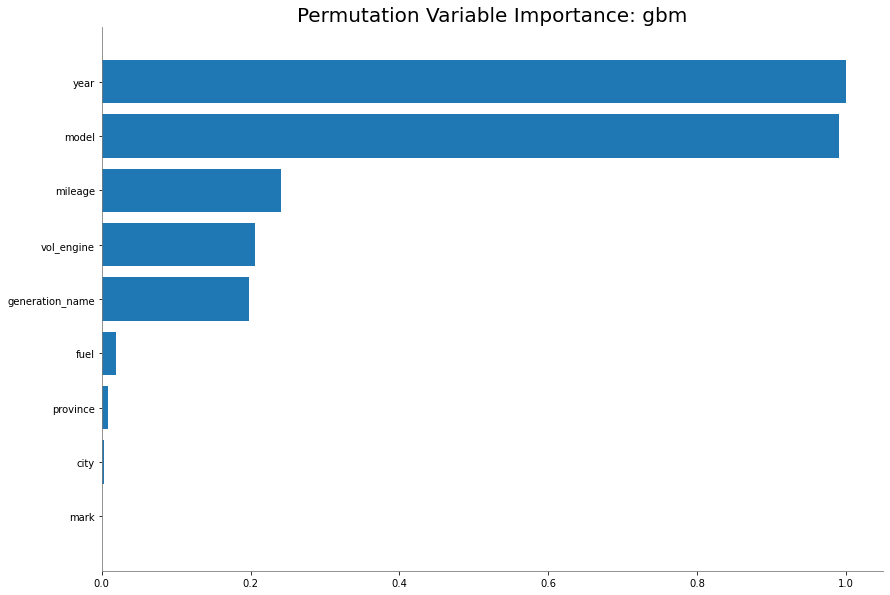

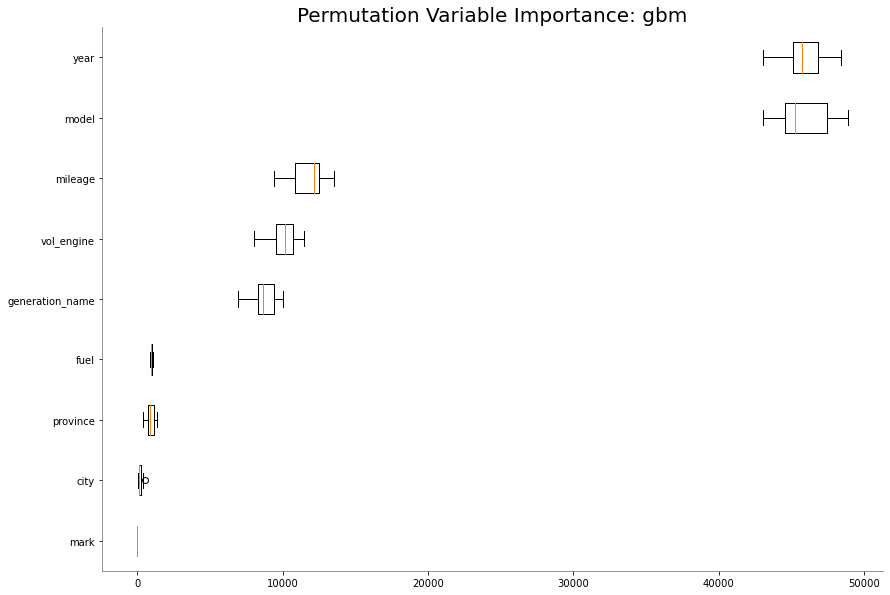

Variable,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9,Run 10,Run 11,Run 12,Run 13,Run 14,Run 15
year,45193.4279285,44490.6205482,45083.8579232,46798.4421729,48174.9886892,46850.5649743,45417.0878836,47382.6801104,46359.0017928,43038.3368374,45702.6331016,46563.0364462,48415.9681728,43799.1573279,45454.9301090
model,44194.5200903,44909.8029636,44514.3920265,47682.1802481,48720.6593286,47360.1074312,44294.9148431,48857.0028882,47539.9529275,43068.0694000,44587.3802681,45035.5669636,47055.1053999,45428.6059147,45217.1586096
mileage,10171.3074170,12197.1883313,10370.4572800,12369.6836945,13490.7314120,13509.2737155,11591.2087957,12461.8179353,12136.4589664,9392.2681177,11454.9591452,12500.5036124,12698.0305625,11344.3403699,10362.1363872
vol_engine,8038.2081144,10255.3851928,9171.6515166,10671.9191458,10634.5516656,11346.9871398,9927.5048431,10963.1607296,10177.1310011,9311.2338896,9735.7336400,10009.5292046,11452.7038960,10763.4667812,9199.2250117
generation_name,6946.9051873,9478.6396956,8280.1643110,9172.1121677,9681.0481832,9771.8159406,8650.0852837,8728.9572982,8310.6333694,7299.7022324,8414.2989343,9259.6054556,10043.3414337,8348.5331424,8057.2660040
province,1312.1667598,782.0049252,408.1240900,906.1251449,1320.6721415,871.0175591,719.7048161,1247.3869129,661.8084054,506.6225914,1031.9929226,1231.8037599,1019.0188892,769.9818109,834.1500521
fuel,914.7488403,996.4474362,1017.0045193,965.3276392,946.3598583,904.9797705,1084.4077266,964.0611850,1005.7748994,986.0049820,943.5292315,905.3013696,958.7337863,1023.8837817,879.2379206
city,141.8479185,257.2086988,134.8745592,119.9938819,154.4321460,291.1770220,190.7443033,110.7434444,21.4666748,555.3359460,113.4582830,90.7294532,102.5189983,177.7003684,358.2610270
mark,3.3642204,4.1221333,7.3267577,0.6028156,8.1422564,2.5367173,1.4306892,9.1131981,5.8960924,1.1467201,3.1889111,7.1569404,6.7387704,0.3904178,0.8433938


In [35]:
# calculate importance
permutation_varimp =model.permutation_importance(test, use_pandas=True)

# plot permutation importance (bar plot)
model.permutation_importance_plot(test)

# plot permutation importance (box plot)
model.permutation_importance_plot(test, n_repeats=15)

The most important feature, according to the permutation variable importance graph you've provided, is "year." It has the highest importance score among all the features listed in the chart.

As for the impact direction or how the "year" feature affects the probability, permutation importance on its own doesn't provide that information. Permutation feature importance only tells us that the "year" feature is important for predictions, not how it affects them.

## Question 3

Calculate absolute error of the price on test dataset. Add absolute error column to the dataset and call it `abs_error`.   

Formula: `abs(price-predict_price)`

In [38]:
predicted = model.predict(test)

# Calculate the absolute errors
abs_error = (test['price'] - predicted).abs()

# Add the absolute error column to the test dataset
test['abs_error'] = abs_error

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [40]:
test

mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price,abs_error
skoda,octavia,gen-iii-2013,2016,63000,1598,Diesel,Szamotuły,Wielkopolskie,49500,7051.7
ford,mustang,,1967,1,6384,Gasoline,Łódź,Łódzkie,379900,28894.9
mini,cooper,,2016,125600,1998,Gasoline,Poznań,Wielkopolskie,99800,26515.4
hyundai,santa-fe,gen-iii-2012-santa-fe,2014,270000,2199,Diesel,Radziejów,Kujawsko-pomorskie,59900,19742.5
renault,clio,gen-v-2019,2019,24000,999,Gasoline,Leszno,Wielkopolskie,56999,5684.47
bmw,seria-3,gen-e46-1998-2007,2003,248000,2171,LPG,Świebodzice,Dolnośląskie,13900,2515.12
volkswagen,tiguan,gen-ii-2016-tiguan,2018,26500,1498,Gasoline,Swarzędz,Wielkopolskie,117500,6469.05
ford,mustang,,1966,47522,4700,Gasoline,Repki,Mazowieckie,59900,60539.3
fiat,500,,2021,7,0,Electric,Warszawa,Mazowieckie,160000,20906.9
volkswagen,caddy,gen-iv-2015,2021,10,1968,Diesel,Łódź,Łódzkie,140046,9094.01


## Question 4

Calculate and display summary plot of Shapley values. Use `test` dataset to calculate Shapley values.

- What is the most important feature based on Shapley values? 
- Based on the Summary plot, how features `year` and `mileage` affect model prediction of the car price?  

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

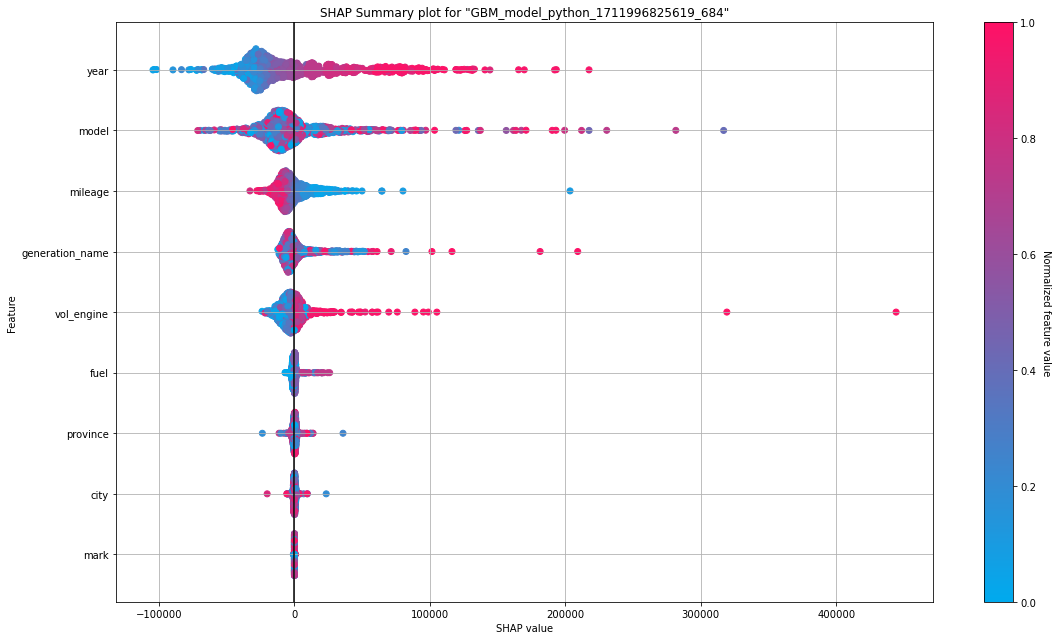

In [43]:
model.explain(test,include_explanations='shap_summary');

The most important feature in the model's prediction of car price is "year," as it has the widest spread of SHAP values and the highest position on the y-axis, which indicates its high level of importance.

or the "year" feature:

Higher SHAP values (right side) are primarily associated with more recent years.
Lower SHAP values (left side) are associated with older years.
This suggests that newer cars tend to have a higher predicted price, while older cars tend to have a lower predicted price, all else being equal.
For the "mileage" feature:

Higher SHAP values (right side) correspond to lower mileage.
Lower SHAP values (left side) correspond to higher mileage.
This indicates that cars with lower mileage tend to be valued higher, and cars with higher mileage are predicted to have lower prices.

## Question 5

Plot individual Shapley values plots for records top 3 and bottom 3 records based on the residuals, for the total of 6 plots.  

Explain each plot in terms of what are most influential features and how they impact model prediction, and why you think model was correct for the top 3 records (smallest residuals) and significantly incorrect for the bottom 3 records (largest residuals).


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

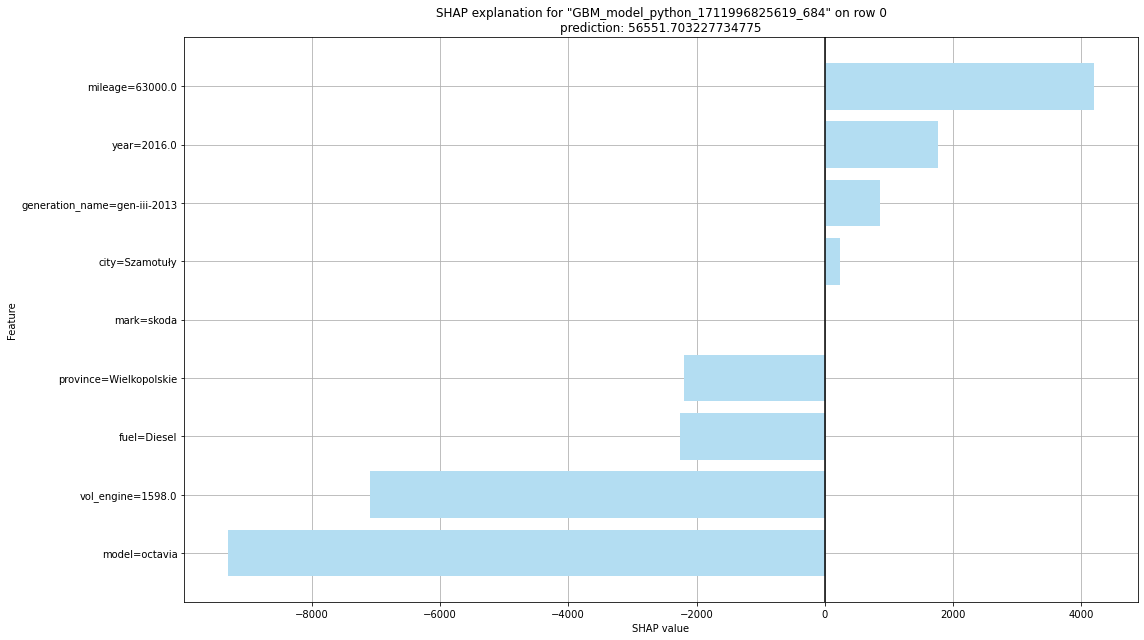

In [49]:
model.explain_row(test,row_index=0,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

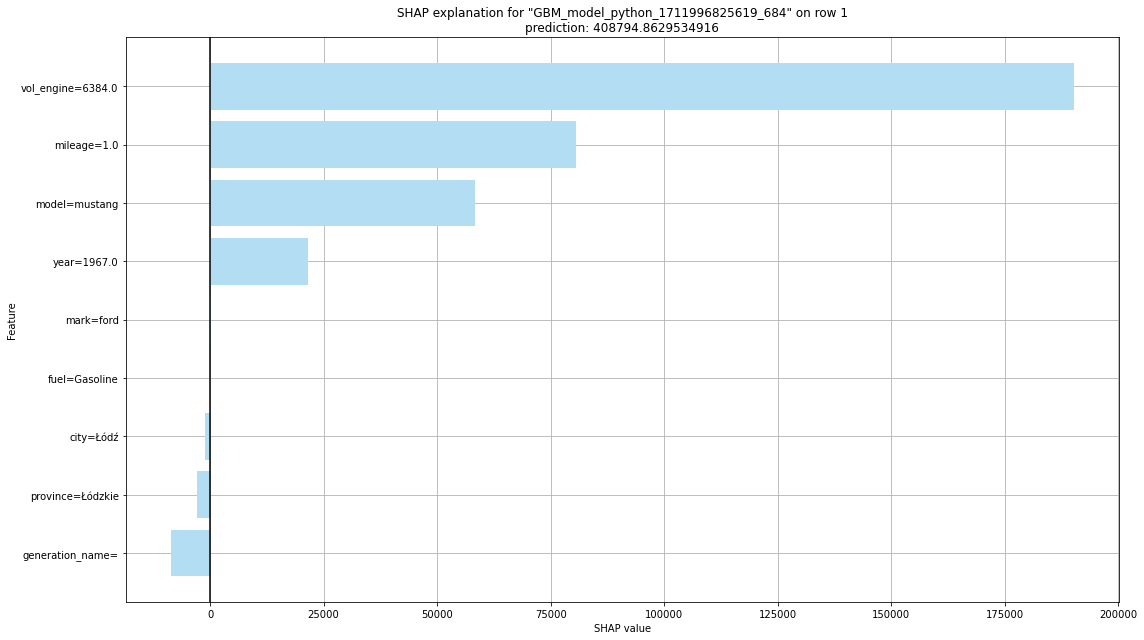

In [50]:
model.explain_row(test,row_index=1,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

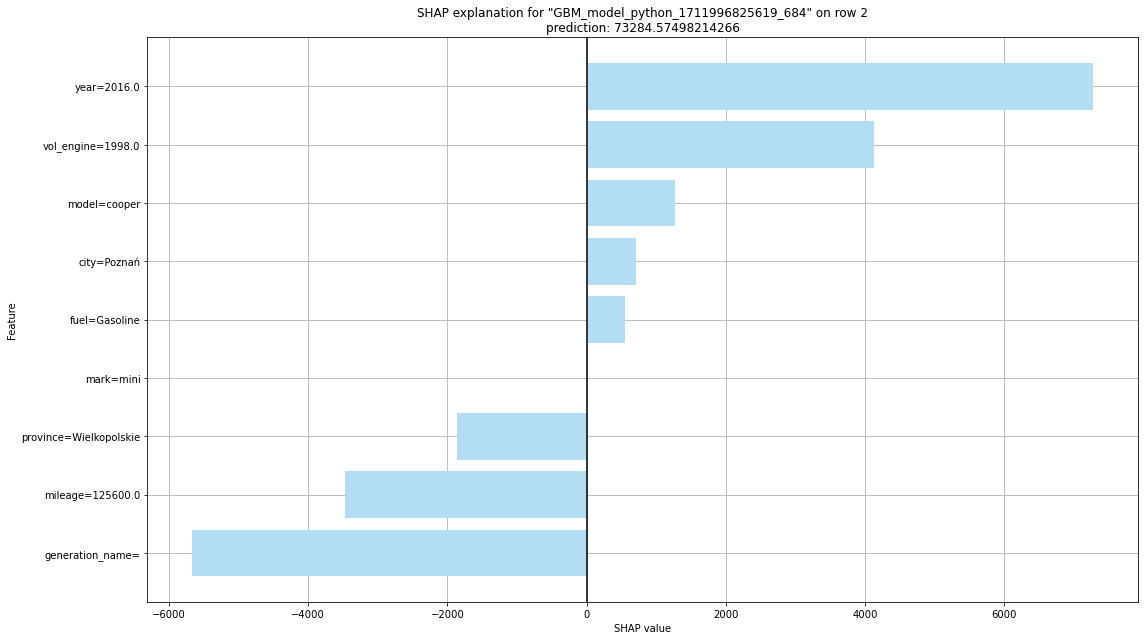

In [51]:
model.explain_row(test,row_index=2,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

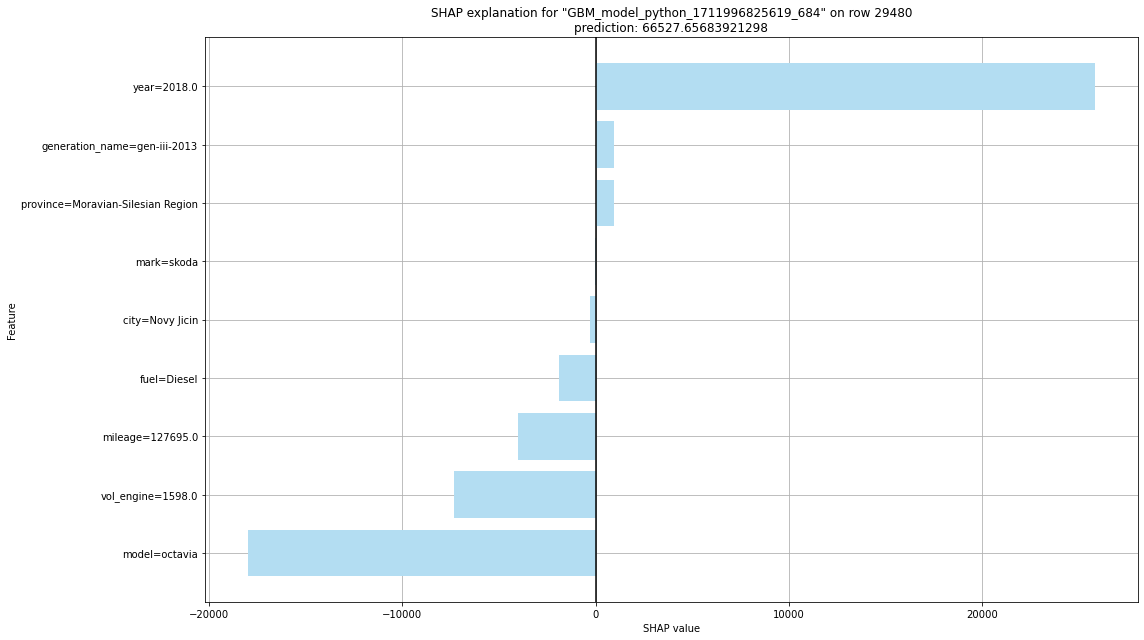

In [63]:
model.explain_row(test,row_index=test.nrow-2,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

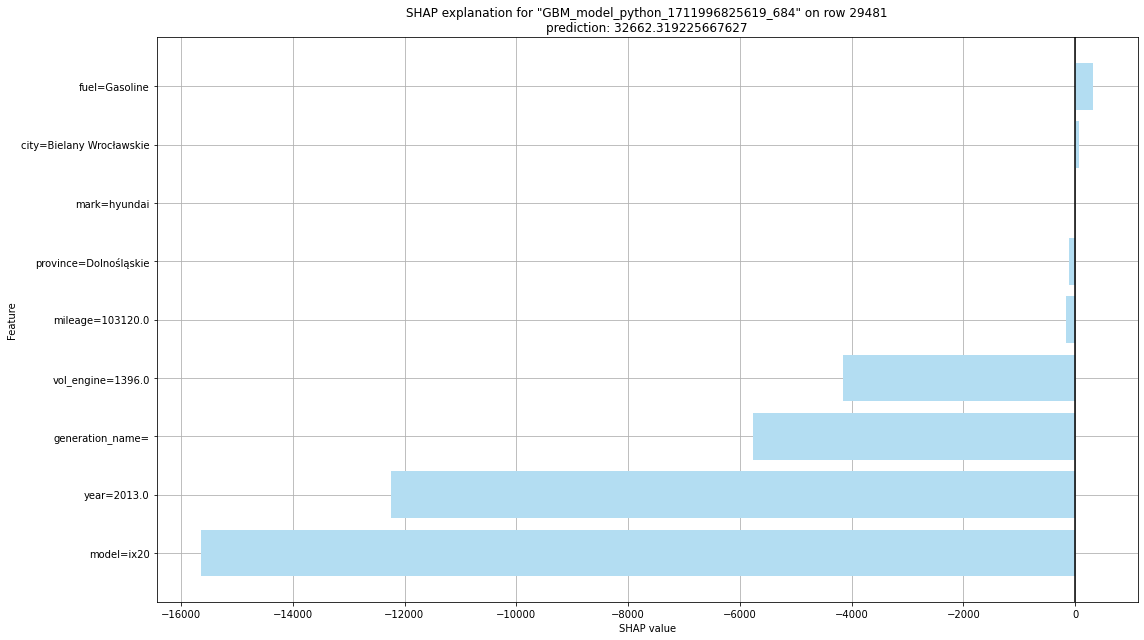

In [65]:
model.explain_row(test,row_index=test.nrow-1,include_explanations='shap_explain_row');

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

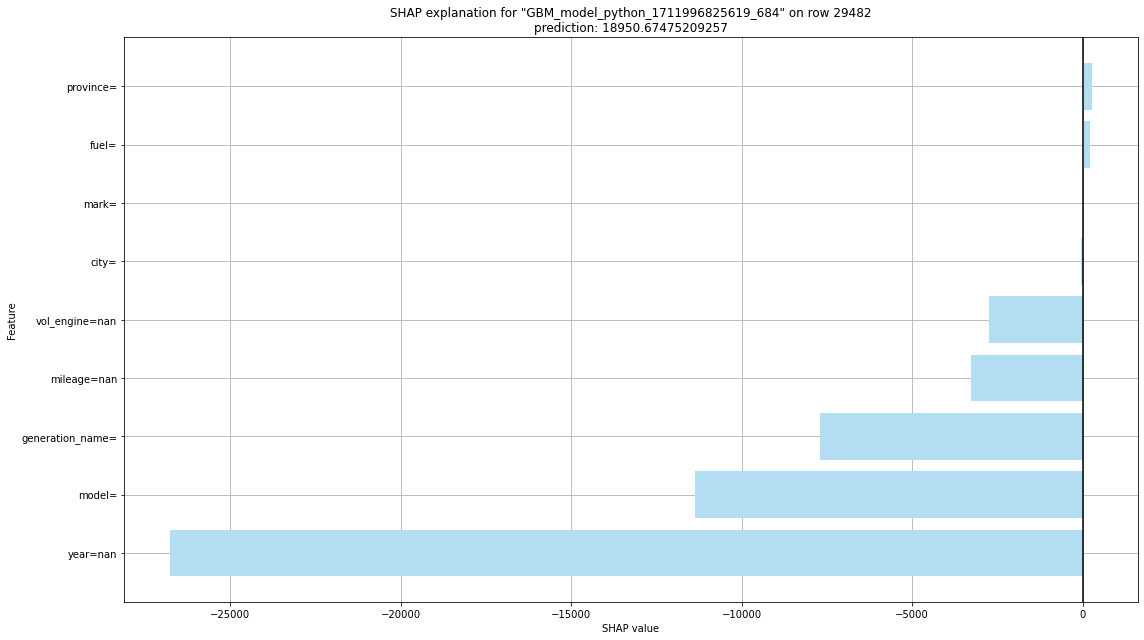

In [67]:
model.explain_row(test,row_index=test.nrow,include_explanations='shap_explain_row');

**Plot 1:**

Most influential features: Mileage has the most substantial influence on the model's prediction.
Impact on prediction: High mileage is contributing to a decrease in the predicted price.
Model accuracy: For this record, which is one of the top three with the smallest residuals, the model's prediction appears accurate, suggesting that the mileage is a critical factor in determining the car price, aligning well with real-world data.

**Plot 2:**

Most influential features: The volume of the engine is the predominant feature.
Impact on prediction: A larger engine size is increasing the predicted price, indicating that the model associates higher engine volume with more value.
Model accuracy: Being among the top three, it seems the model's representation of engine size effect is consistent with the actual effect on car pricing.

**Plot 3:**

Most influential features: The year of the car and the volume of the engine are crucial.
Impact on prediction: Newer car years and larger engines have a positive influence on the price prediction.
Model accuracy: As this record is one of the top three, the prediction is quite accurate, suggesting the model correctly estimates the impact of recent years and engine size on car prices.

**Plot 4:**

Most influential features: Year and generation name appear to be significant.
Impact on prediction: Both are contributing positively to the price prediction, perhaps overestimating the price.
Model accuracy: This plot corresponds to one of the bottom three records with the largest residuals, indicating potential overemphasis on the model's part or other missing factors that influence the car's price.

**Plot 5:**

Most influential features: Mileage is the standout feature.
Impact on prediction: The model predicts a lower price with higher mileage, which might be exaggerated in this case.
Model accuracy: Given this is a bottom-three record, the model might be overly penalizing high mileage or missing other value-retaining factors.

**Plot 6:**

Most influential features: Mileage and engine volume are prominent.
Impact on prediction: High mileage significantly lowers the price prediction, whereas a larger engine size increases it.
Model accuracy: This plot shows another bottom-three record, suggesting that the model may not capture some nuances, such as the interplay between high mileage and engine volume or other valuable features not included in the model.

## Question 6 

Train new H2O GBM model on the test dataset trying to predict residuals. This is your surrogate model that you will use to understand what features are driving high residuals.   

Use same parameters as in question #1, except:
  - predictor is now "abs_error"
  - dataset now is "test" dataset
  - make sure not to include original "price" column in the model

Plot Shapley summary plot for the top 100 records with highest residuals.
Answer following question:
  - What is the most important feature of the surrogate model that impacts high residuals?

In [113]:
if 'price' in test.columns:
    test = test.drop('price')

# Define the model with the specified parameters, targeting 'abs_error' this time
surrogate_model = H2OGradientBoostingEstimator(
    nfolds=5,
    ntrees=500,
    stopping_rounds=5,
    stopping_metric='MAE',
    seed=1234,
    keep_cross_validation_predictions=False
)

# Train the surrogate model to predict 'abs_error'
# Ensure 'abs_error' is your target variable and the rest are features
surrogate_model.train(y='abs_error', training_frame=test)

# Surrogate model is now trained to predict residuals.

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1711996825619_685


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    49                 49                          34701                  5            5            5             8             31            19.9184

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 109764223.20005392
RMSE: 10476.842234187452
MAE: 4943.227617691289
RMSLE: 1.217642232103816
Mean Residual Deviance: 109764223.20005392

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 174241595.31206802
RMSE: 13200.060428349107
MAE: 5461.423549595423
RMSLE: NaN
Mean Residual Deviance: 174241595.31206802

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     5462.68      81.4431      5580.38       5422.2        5423.97       5377.09       5509.75
mean_residual_deviance  1.74558e+08  2.13932e+07  1.88194e+08   1.6353e+08    1.54902e+08   1.60818e+08   2.05347e+08
mse                     1.74558e+08  2.13932e+07  1.88194e+08   1.6353e+08    1.54902e+08   1.60818e+08   2.05347e+08
r2                      0.365339     0.0409742    0.322449      0.394899      0.40044       0.390042      0.318865
residual_deviance       1.74558e+08  2.13932e+07  1.88194e+08   1.6353e+08    1.54902e+08   1.60818e+08   2.05347e+08
rmse                    13192.7      798.84       13718.4       12787.9       12445.9       12681.4       14329.9
rmsle                   1.24624      0.00750382   1.24084       nan           1.24307       1.25481       nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2024-04-10 17:19:10  1.859 sec   0.0                16561.55545132705   7950.844659381112   274285118.96738076
     2024-04-10 17:19:10  1.867 sec   1.0                15873.291783631885  7533.457131384562   251961392.0483155
     2024-04-10 17:19:10  1.873 sec   2.0                15301.743877035497  7188.685954516446   234143365.67839333
     2024-04-10 17:19:10  1.879 sec   3.0                14799.807299741846  6894.731263362866   219034296.109492
     2024-04-10 17:19:10  1.885 sec   4.0                14369.429135785012  6650.189384592028   206480493.6883472
     2024-04-10 17:19:10  1.891 sec   5.0                13982.378002553793  6436.503274194555   195506894.60630018
     2024-04-10 17:19:10  1.896 sec   6.0                13681.317004177192  6264.6820234068655  187178434.96878797
     2024-04-10 17:19:10  1.902 sec   7.0                13408.068465095741  6113.648543331894   179776299.96469486
     2024-04-10 17:19:10  1.908 sec   8.0                13159.860227018407  5983.675590572186   173181921.19466096
     2024-04-10 17:19:10  1.914 sec   9.0                12918.008635346718  5866.332783281932   166874947.10289237
---  ---                  ---         ---                ---                 ---                 ---
     2024-04-10 17:19:10  2.090 sec   40.0               10678.376131444336  4983.66470892012    114027716.80460012
     2024-04-10 17:19:10  2.096 sec   41.0               10620.233195531588  4975.406647985793   112789353.12747109
     2024-04-10 17:19:10  2.101 sec   42.0               10611.99205471606   4973.044411508941   112614375.36935678
     2024-04-10 17:19:10  2.106 sec   43.0               10

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

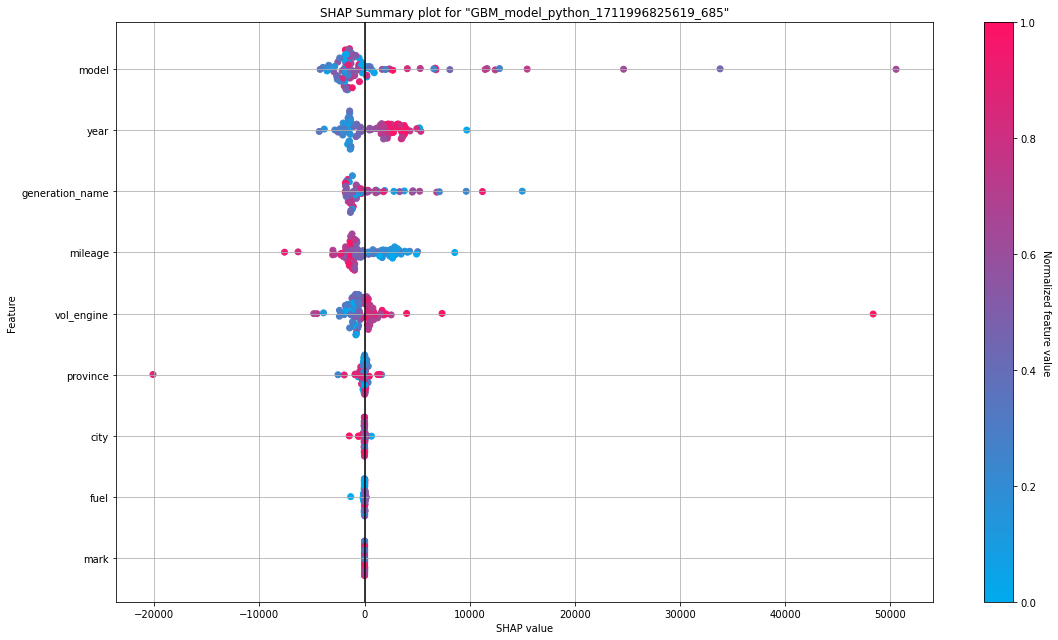

In [131]:
surrogate_model.explain(test[0:100,:],include_explanations='shap_summary');

The most important feature in the model's prediction of residual is "model," as it has the widest spread of SHAP values and the highest position on the y-axis, which indicates its high level of importance.